In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [3]:
# 세로 이미지에 좌우 여백을 추가 (세로 사이즈로 통일)
def add_padding_left_right(img:np.ndarray, color) -> np.ndarray:
    padding = (img.shape[0] - img.shape[1]) // 2
    img = cv2.copyMakeBorder(img, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return img

# 이미지 회전
# bg_color -> 회전하고 남은 여백을 채울 색깔
def rotate_img(img:np.ndarray, degree, bg_color) -> np.ndarray:
    h, w = img.shape[:2]
    cy, cx = (h // 2), (w // 2)
    M = cv2.getRotationMatrix2D((cx, cy), degree, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderValue=bg_color)
    return img

(128, 128, 3)


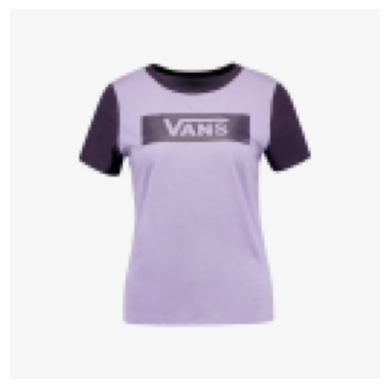

In [4]:
# 데이터 미리보기 

img = cv2.imread('./dataset/00055_00.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = add_padding_left_right(img, color=(246, 246, 246))
img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
img = rotate_img(img, 0, bg_color=(246, 246, 246))

print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()




In [5]:
image_files = np.array([os.path.join('./cloth', file) for file in os.listdir('./cloth')])
mask = np.random.choice(len(image_files), int(len(image_files) * 0.2), replace=False)

train_data = [] # (label, img)
test_data = []

for i in range(len(image_files)):
    img = cv2.imread(image_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = add_padding_left_right(img, color=(246, 246, 246))
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

    degrees = np.random.choice(range(360), 5, replace=False)
    for degree in degrees:
        rotated_img = rotate_img(img, degree, bg_color=(246, 246, 246))

        if i in mask:
            test_data.append((rotated_img, degree))
        else:
            train_data.append((rotated_img, degree))

print(len(train_data), len(test_data))

8130 2030


<Axes: ylabel='Count'>

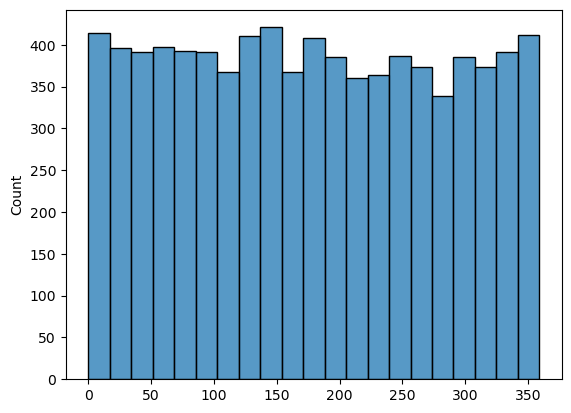

In [6]:
sns.histplot([x[1] for x in train_data])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_list) -> None:
        super().__init__()
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # 정규화, 
        sample = torch.tensor(self.data[index][0]).float()
        label = torch.tensor(self.data[index][1]).float()
        return sample, label

train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
for data in train_loader:
    x, y = data
    print(x.shape, y.shape)
    break

torch.Size([32, 128, 128]) torch.Size([32])


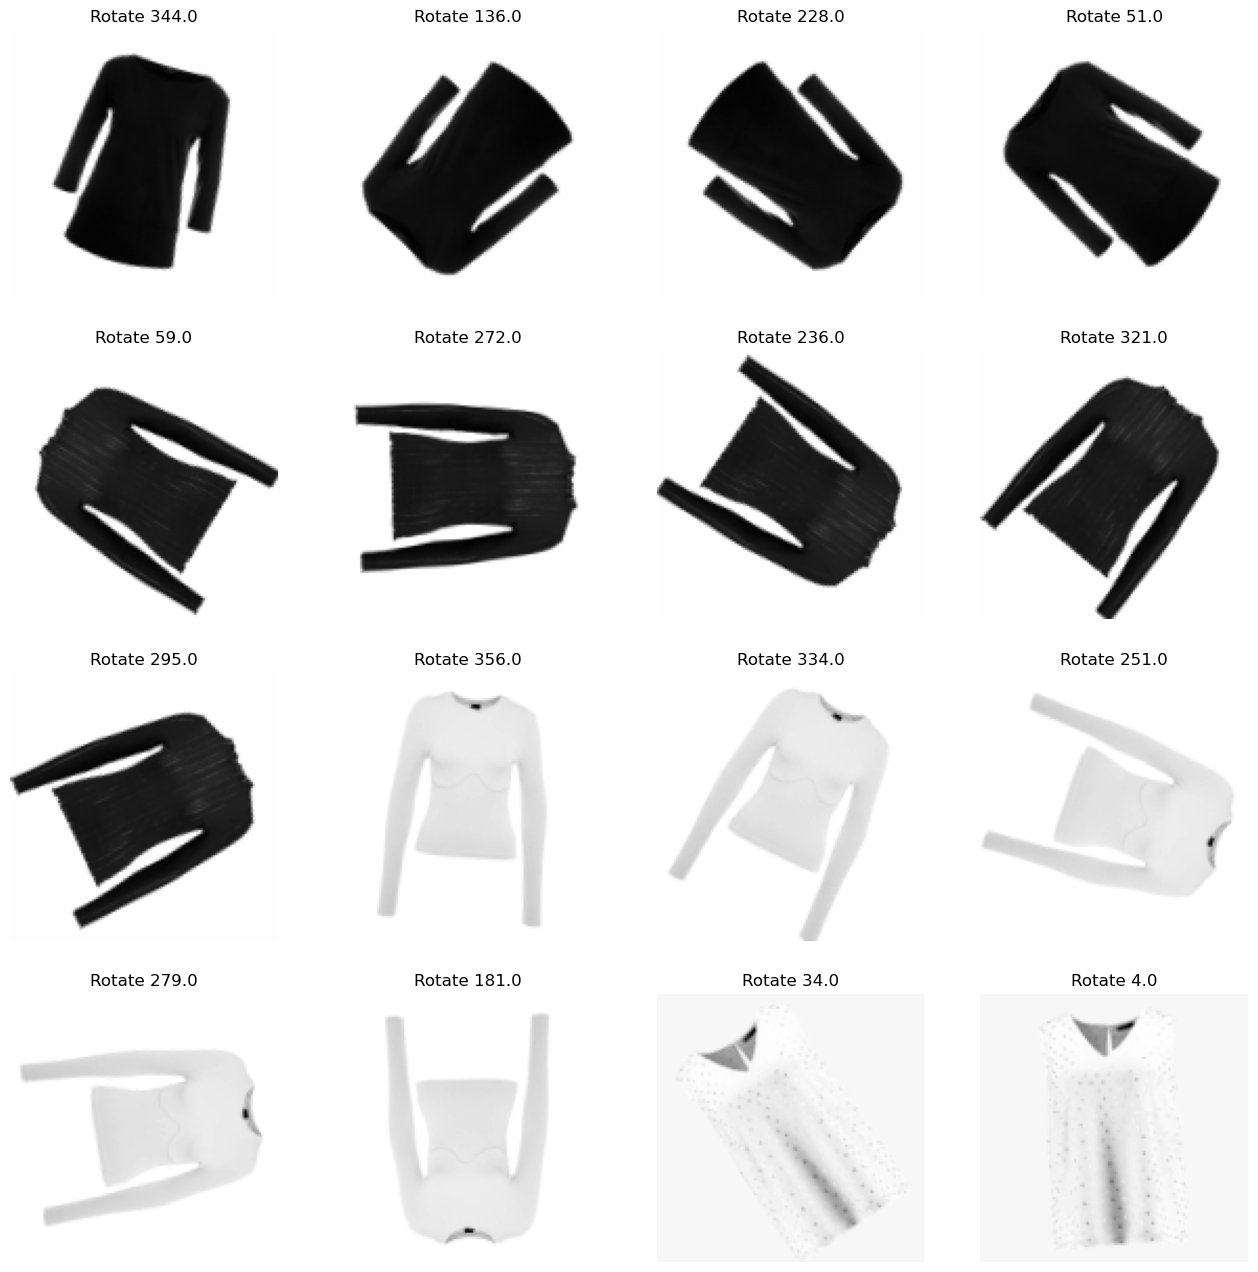

In [10]:
data = next(iter(test_loader))

fig = plt.figure(figsize=(16, 16))
colums = 4
rows = 4
for i in range(1, colums * rows + 1):
    img = test_dataset[i][0].int() # 28x28 이미지
    fig.add_subplot(rows, colums, i)
    plt.title(f'Rotate {test_dataset[i][1]}')
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [11]:
128*16*16

32768

In [12]:
class ClothAngleCorrection(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 3x128x128 -> 32x128x128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128 -> 32x64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32x64x64 -> 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64 -> 64x32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64x32x32 -> 128x32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32 -> 128x16x16
        )

        self.fc = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    
    def forward(self, x:torch.Tensor):
        x = self.layer(x)
        x = x.view(-1, 128*16*16)
        x = self.fc(x)
        return x
        

In [13]:
model = ClothAngleCorrection()
model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

ClothAngleCorrection(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=32768, out_features=256, bias=True)
    (1): Dropout(p=0.5, inplace=Fals

In [14]:
# 모델 학습

num_epochs = 10
count = 0

train_loss = []
test_loss = []



for epoch in range(num_epochs):
    epoch_train_loss = []
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        x_train = Variable(x_train.view(-1, 1, 128, 128))
        y_train = Variable(y_train)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        epoch_train_loss.append(loss.data.cpu())


    train_loss.append(np.mean(epoch_train_loss))

    epoch_test_loss = []
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        x_test = x_test

        with torch.no_grad():
            outputs = model(x_test.view(-1, 1, 128, 128))
            loss = criterion(outputs, y_test)
            
            epoch_test_loss.append(loss.data.cpu())
    
    test_loss.append(np.mean(epoch_test_loss))
        
    
    print(f'Epoch: {epoch}, Train_MSE:{np.mean(epoch_train_loss)}, Test_MSE:{np.mean(epoch_test_loss)}')
            
    
    

Epoch: 0, Train_MSE:11730.6015625, Test_MSE:12424.634765625
Epoch: 1, Train_MSE:11564.525390625, Test_MSE:12616.82421875
Epoch: 2, Train_MSE:11504.6875, Test_MSE:11586.888671875
Epoch: 3, Train_MSE:11406.2138671875, Test_MSE:11145.1171875
Epoch: 4, Train_MSE:11351.5546875, Test_MSE:11692.25
Epoch: 5, Train_MSE:11358.591796875, Test_MSE:11457.337890625
Epoch: 6, Train_MSE:11336.3310546875, Test_MSE:11122.6640625
Epoch: 7, Train_MSE:11259.736328125, Test_MSE:11811.03125
Epoch: 8, Train_MSE:11279.5, Test_MSE:11059.560546875
Epoch: 9, Train_MSE:11326.7822265625, Test_MSE:11148.6435546875


In [15]:
train_loss

[11730.602,
 11564.525,
 11504.6875,
 11406.214,
 11351.555,
 11358.592,
 11336.331,
 11259.736,
 11279.5,
 11326.782]